## Hypothesis

* What linguistic features might be influencing the classifier's decisions:  

1. The average Kband of the transcript - The more popular the talk, the lower the Kband mean.
    Why? Because we usually don't want the speaker to use a lot of terminologies that are only used in the field they explain or work.  

2. _need to think about one more feature that might affect the classifier's decision.._

* How to define _popular_ talk?  
Mainly `comments` column since it has higher level of engagement than `view`.
But I am planning to figure out how to incorporate the `view` information too

## Regression using K-band

In [1]:
import pandas as pd
import numpy as np
import math
import nltk
import matplotlib as plt
import sklearn               
import seaborn as sns

In [2]:
# read files
ted_main = pd.read_csv("../data/ted_main.csv")
tran = pd.read_csv("../data/transcripts.csv")

In [3]:
# remove NAs
ted_main.dropna(inplace=True)
tran.dropna(inplace=True)

In [4]:
# sorting the main TED conference 
ted_main = ted_main[ted_main['event'].str.fullmatch(r'TED\d\d\d\d')]


In [5]:
# combine two files
ted = pd.merge(ted_main, tran, on = 'url')
ted.head(6)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,transcript
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,Good morning. How are you?(Laughter)It's been ...
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,"Thank you so much, Chris. And it's truly a gre..."
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292,"(Music: ""The Sound of Silence,"" Simon & Garfun..."
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550,If you're here today — and I'm very happy that...
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869,"About 10 years ago, I took on the task to teac..."
5,672,"Tony Robbins discusses the ""invisible forces"" ...",1305,TED2006,1138838400,36,Tony Robbins,Tony Robbins: Why we do what we do,1,1151440680,"[{'id': 7, 'name': 'Funny', 'count': 1102}, {'...","[{'id': 229, 'hero': 'https://pe.tedcdn.com/im...",Life coach; expert in leadership psychology,"['business', 'culture', 'entertainment', 'goal...",Why we do what we do,https://www.ted.com/talks/tony_robbins_asks_wh...,20685401,Thank you. I have to tell you I'm both challen...


* While merging two dataset, 5 values are lost. Not sure what happened..

In [6]:
# select the columns I need
ted_clean = ted[['title', 'event', 'comments', 'ratings', 'transcript']]
ted_clean

,title,event,comments,ratings,transcript
0,Do schools kill creativity?,TED2006,4553,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...",Good morning. How are you?(Laughter)It's been ...
1,Averting the climate crisis,TED2006,265,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","Thank you so much, Chris. And it's truly a gre..."
2,Simplicity sells,TED2006,124,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","(Music: ""The Sound of Silence,"" Simon & Garfun..."
3,Greening the ghetto,TED2006,200,"[{'id': 3, 'name': 'Courageous', 'count': 760}...",If you're here today — and I'm very happy that...
4,The best stats you've ever seen,TED2006,593,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","About 10 years ago, I took on the task to teac..."
...,...,...,...,...,...
967,How digital DNA could help you make better hea...,TED2017,7,"[{'id': 1, 'name': 'Beautiful', 'count': 13}, ...","Today I'm here, actually, to pose you a questi..."
968,What we're missing in the debate about immigra...,TED2017,17,"[{'id': 3, 'name': 'Courageous', 'count': 24},...","So, Ma was trying to explain something to me a..."
969,The most Martian place on Earth,TED2017,6,"[{'id': 22, 'name': 'Fascinating', 'count': 32...",This is a picture of a sunset on Mars taken by...
970,What intelligent machines can learn from a sch...,TED2017,10,"[{'id': 1, 'name': 'Beautiful', 'count': 14}, ...","In my early days as a graduate student, I went..."


In [7]:
# tokenize the transcript
ted_clean['token'] = ted_clean.transcript.map(nltk.word_tokenize)

C:\Users\82102\AppData\Local\Temp\ipykernel_10608\1970647423.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ted_clean['token'] = ted_clean.transcript.map(nltk.word_tokenize)


In [8]:
# code from stackoverflow: https://stackoverflow.com/questions/51688521/lowercase-sentences-in-lists-in-pandas-dataframe
ted_clean['tok_low'] = ted_clean.token.map(lambda x: list(map(str.lower, x)))

C:\Users\82102\AppData\Local\Temp\ipykernel_10608\2834919379.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ted_clean['tok_low'] = ted_clean.token.map(lambda x: list(map(str.lower, x)))


In [9]:
ted_clean.sample(5)

,title,event,comments,ratings,transcript,token,tok_low
348,The world's English mania,TED2009,588,"[{'id': 23, 'name': 'Jaw-dropping', 'count': 1...",Let's talk about manias. Let's start with Beat...,"[Let, 's, talk, about, manias, ., Let, 's, sta...","[let, 's, talk, about, manias, ., let, 's, sta..."
915,"When Black women walk, things change",TED2017,48,"[{'id': 1, 'name': 'Beautiful', 'count': 175},...","Vanessa Garrison: I am Vanessa, daughter of An...","[Vanessa, Garrison, :, I, am, Vanessa, ,, daug...","[vanessa, garrison, :, i, am, vanessa, ,, daug..."
361,How cults rewire the brain,TED2009,642,"[{'id': 23, 'name': 'Jaw-dropping', 'count': 4...",My journey to coming here today started in 197...,"[My, journey, to, coming, here, today, started...","[my, journey, to, coming, here, today, started..."
135,Underwater astonishments,TED2007,554,"[{'id': 23, 'name': 'Jaw-dropping', 'count': 8...","We're going to go on a dive to the deep sea, a...","[We, 're, going, to, go, on, a, dive, to, the,...","[we, 're, going, to, go, on, a, dive, to, the,..."
930,Don't feel sorry for refugees -- believe in them,TED2017,66,"[{'id': 10, 'name': 'Inspiring', 'count': 145}...",I remember when I first found out I was going ...,"[I, remember, when, I, first, found, out, I, w...","[i, remember, when, i, first, found, out, i, w..."


In [10]:
# read files to make kband for the transcript analysis
# Codes created by Dr. Han
flines = open("C://Users//82102//Desktop//program//2022 fall//LING 2231//count_1w.txt").readlines()
google_1gram_tup = [tuple(line.split()) for line in flines]
google_1gram_rank = {word:index+1 for (index,(word, count)) in enumerate(google_1gram_tup)}

In [11]:
# Build kband function, using the code Dr. Han created
def get_avg_google_kband(toks):
    kbands = []
    for t in toks:
        if t.lower() in google_1gram_rank: 
           grank = google_1gram_rank[t.lower()]
           if grank <= 100000:  
               kband = math.floor(grank/1000)+1
               kbands.append(kband)
    return np.mean(kbands)

In [12]:
get_avg_google_kband(ted_clean.token[0])

2.712989957887917

* Nice it works.

In [13]:
ted_clean['kband_ave'] = ted_clean.token.map(get_avg_google_kband)

C:\Users\82102\AppData\Local\Temp\ipykernel_10608\888917555.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ted_clean['kband_ave'] = ted_clean.token.map(get_avg_google_kband)


In [14]:
ted_clean.describe()

,comments,kband_ave
count,972.000000,972.000000
mean,212.526749,3.127864
std,371.132528,0.927790
min,6.000000,1.858444
25%,64.000000,2.637509
50%,121.500000,2.959547
75%,233.000000,3.404999
max,6404.000000,13.780000


* There are some unexpectedly high mean Kbands.. Let's see what they are.

In [15]:
# check the max kband_ave because it does not make sense..
ted_clean[ted_clean.kband_ave == 13.78]

,title,event,comments,ratings,transcript,token,tok_low,kband_ave
76,"""La Vie en Rose""",TED2004,39,"[{'id': 7, 'name': 'Funny', 'count': 58}, {'id...",Thomas Dolby: For pure pleasure please welcome...,"[Thomas, Dolby, :, For, pure, pleasure, please...","[thomas, dolby, :, for, pure, pleasure, please...",13.78


In [16]:
# checking the token # to check if the token number is causing this problem
ted_clean[ted_clean.kband_ave == 13.78]['token'].map(len)

76    151
Name: token, dtype: int64

In [17]:
# check which talk has a kband mean higher than
ted_clean[ted_clean.kband_ave >= 5]['token'].map(len)

62     1314
64      185
76      151
113       9
215     583
293    1198
310    3294
382      53
496      12
575      24
648    1728
678    2323
801     514
802      12
948     420
Name: token, dtype: int64

* There are total 20 of them whose average kband is higher than 5. Let's check each one of them and see if we should remove them or not.  
* Maybe #1792 should be removed..  
* Or, is this the problem of the limit when I make kband? Should I narrow it down?.. Hmm..

In [18]:
ted_clean = ted_clean[ted_clean.kband_ave <= 5]

In [19]:
ted_clean.kband_ave.describe()

count    957.000000
mean       3.051115
std        0.590399
min        1.858444
25%        2.635417
50%        2.950445
75%        3.382574
max        4.972222
Name: kband_ave, dtype: float64

In [156]:
# reset index
ted_clean.reset_index(drop=True, inplace=True)

c:\Users\82102\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='comments', ylabel='kband_ave'>

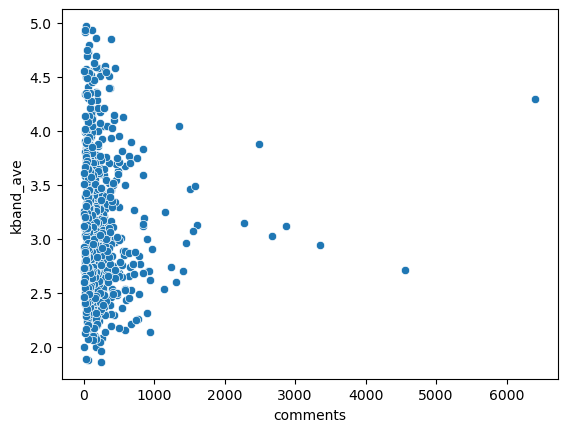

In [21]:
sns.scatterplot(ted_clean['comments'], ted_clean['kband_ave'])

In [22]:
ted_clean['comments'].median()
# ted_clean['comments'].min()

124.0

* median이 124니까 124이상은 인기 124 이하는 비인기로 나눌까?

## Ratings - feature engineering

* ratings: string임.

In [158]:
import re

In [159]:
ted_clean['ratings_tok'] = ted_clean.ratings.map(lambda x: re.sub(r'\[|\]|\{|\}|:|,|\'', '', x))

C:\Users\82102\AppData\Local\Temp\ipykernel_10608\2408897178.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ted_clean['ratings_tok'] = ted_clean.ratings.map(lambda x: re.sub(r'\[|\]|\{|\}|:|,|\'', '', x))


In [160]:
ted_clean.head()

,title,event,comments,ratings,transcript,token,tok_low,kband_ave,ratings_tok,TEST
0,Do schools kill creativity?,TED2006,4553,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...",Good morning. How are you?(Laughter)It's been ...,"[Good, morning, ., How, are, you, ?, (, Laught...","[good, morning, ., how, are, you, ?, (, laught...",2.712990,id 7 name Funny count 19645 id 1 name Beautifu...,Funny:19645\n Beautiful:4573\n Ingen...
1,Averting the climate crisis,TED2006,265,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","Thank you so much, Chris. And it's truly a gre...","[Thank, you, so, much, ,, Chris, ., And, it, '...","[thank, you, so, much, ,, chris, ., and, it, '...",2.777508,id 7 name Funny count 544 id 3 name Courageous...,Funny:544\n Courageous:139\n Confus...
2,Simplicity sells,TED2006,124,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","(Music: ""The Sound of Silence,"" Simon & Garfun...","[(, Music, :, ``, The, Sound, of, Silence, ,, ...","[(, music, :, ``, the, sound, of, silence, ,, ...",2.750460,id 7 name Funny count 964 id 3 name Courageous...,Funny:964\n Courageous:45\n Ingenio...
3,Greening the ghetto,TED2006,200,"[{'id': 3, 'name': 'Courageous', 'count': 760}...",If you're here today — and I'm very happy that...,"[If, you, 're, here, today, —, and, I, 'm, ver...","[if, you, 're, here, today, —, and, i, 'm, ver...",3.192360,id 3 name Courageous count 760 id 1 name Beaut...,Courageous:760\n Beautiful:291\n Confus...
4,The best stats you've ever seen,TED2006,593,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","About 10 years ago, I took on the task to teac...","[About, 10, years, ago, ,, I, took, on, the, t...","[about, 10, years, ago, ,, i, took, on, the, t...",2.155352,id 9 name Ingenious count 3202 id 7 name Funny...,Ingenious:3202\n Funny:1390\n Beau...


In [161]:
rating_name = []
for i in ted_clean.ratings_tok.map(nltk.word_tokenize):
    for j in i:
        if j[0].isupper():
            rating_name.append(j) 
print(list(set(rating_name)))

['Longwinded', 'Confusing', 'OK', 'Ingenious', 'Courageous', 'Unconvincing', 'Funny', 'Informative', 'Jaw-dropping', 'Obnoxious', 'Fascinating', 'Beautiful', 'Persuasive', 'Inspiring']


In [162]:
len(set(rating_name))

14

* So, there are 14 different rating kinds.
* 4 out of 14 ratings are negative ratings

In [163]:
negative = ['Unconvincing', 'Obnoxious', 'Confusing', 'Longwinded']
positive = [w for w in set(rating_name) if w not in negative]

In [164]:
rating_split = ted_clean['ratings_tok'].str.split(' ')

In [165]:
# !!!!!!!!!!!!!!!
rating_split.str.get(0)

0      id
1      id
2      id
3      id
4      id
       ..
952    id
953    id
954    id
955    id
956    id
Name: ratings_tok, Length: 957, dtype: object

In [166]:
x = []
for i in range(3, 85, 6):
    x.append(rating_split.str.get(i))
print(x)

[0             Funny
1             Funny
2             Funny
3        Courageous
4         Ingenious
           ...     
952       Beautiful
953      Courageous
954     Fascinating
955       Beautiful
956    Unconvincing
Name: ratings_tok, Length: 957, dtype: object, 0        Beautiful
1       Courageous
2       Courageous
3        Beautiful
4            Funny
          ...     
952    Informative
953    Informative
954    Informative
955    Informative
956    Informative
Name: ratings_tok, Length: 957, dtype: object, 0      Ingenious
1      Confusing
2      Ingenious
3      Confusing
4      Beautiful
         ...    
952    Inspiring
953    Inspiring
954    Inspiring
955    Ingenious
956    Inspiring
Name: ratings_tok, Length: 957, dtype: object, 0      Courageous
1       Beautiful
2       Beautiful
3           Funny
4      Courageous
          ...    
952     Ingenious
953         Funny
954    Persuasive
955     Inspiring
956            OK
Name: ratings_tok, Length: 957, dtype: objec

In [167]:
y = []
for i in range(5, 85, 6):
    y.append(rating_split.str.get(i))
print(pd.DataFrame(y))

               0    1    2     3     4     5     6    7    8     9    ...  \
ratings_tok  19645  544  964   760  3202  1102   477  195  562   838  ...   
ratings_tok   4573  139   45   291  1390   721  2484   98   70   767  ...   
ratings_tok   6073   62  183    32   942   377   320   26  283   476  ...   
ratings_tok   3253   58   60    59   318   301   225   34   60   116  ...   
ratings_tok    387  258  104   105   110   706   277   26  177   306  ...   
ratings_tok    242  113   78    36    72   397    72  175  211   111  ...   
ratings_tok   7346  443  395    53    67   285   226  121  145   304  ...   
ratings_tok  10581  413  230   380  5433  1038   438  153  623  2556  ...   
ratings_tok    300  132  166  1070  2893  5211   316   25  441   459  ...   
ratings_tok  10704   56   27   132  4606  1350   193   37  313    26  ...   
ratings_tok   4439  268  146   460  3736  2423   311   63  764  1543  ...   
ratings_tok   1174  116  230   230  2542   441   308   57   60   371  ...   

In [313]:
#len(pd.DataFrame(x).columns)
X = pd.DataFrame(x)
Y = pd.DataFrame(y)
X.reset_index(drop = True, inplace = True)
Y.reset_index(drop = True, inplace = True)

In [314]:
X

,0,1,2,3,4,5,6,7,8,9,...,947,948,949,950,951,952,953,954,955,956
0,Funny,Funny,Funny,Courageous,Ingenious,Funny,Courageous,Ingenious,Courageous,Unconvincing,...,Confusing,OK,Beautiful,Beautiful,Inspiring,Beautiful,Courageous,Fascinating,Beautiful,Unconvincing
1,Beautiful,Courageous,Courageous,Beautiful,Funny,Courageous,Funny,Beautiful,Confusing,Beautiful,...,Funny,Informative,Persuasive,Courageous,Informative,Informative,Informative,Informative,Informative,Informative
2,Ingenious,Confusing,Ingenious,Confusing,Beautiful,Unconvincing,Ingenious,Longwinded,Unconvincing,Courageous,...,Ingenious,Inspiring,Ingenious,Informative,Ingenious,Inspiring,Inspiring,Inspiring,Ingenious,Inspiring
3,Courageous,Beautiful,Beautiful,Funny,Courageous,Confusing,Unconvincing,Courageous,Funny,Ingenious,...,Fascinating,Fascinating,Jaw-dropping,Inspiring,Fascinating,Ingenious,Funny,Persuasive,Inspiring,OK
4,Longwinded,Unconvincing,Unconvincing,Ingenious,Longwinded,Beautiful,Beautiful,Unconvincing,Longwinded,Longwinded,...,Inspiring,Courageous,Inspiring,OK,Persuasive,Courageous,Persuasive,Jaw-dropping,Courageous,Fascinating
5,Confusing,Longwinded,Longwinded,Unconvincing,Confusing,Ingenious,Confusing,Inspiring,Ingenious,Confusing,...,Beautiful,Ingenious,Courageous,Persuasive,Beautiful,Confusing,Ingenious,Ingenious,Confusing,Ingenious
6,Informative,Informative,Informative,Longwinded,Unconvincing,Longwinded,Informative,Informative,Beautiful,Informative,...,Jaw-dropping,Persuasive,Fascinating,Fascinating,Courageous,OK,Fascinating,Funny,Fascinating,Confusing
7,Fascinating,Inspiring,Inspiring,Informative,Informative,Informative,Inspiring,Fascinating,Informative,Inspiring,...,Informative,Funny,Unconvincing,Confusing,Jaw-dropping,Persuasive,Beautiful,Beautiful,Unconvincing,Obnoxious
8,Unconvincing,Fascinating,Fascinating,Inspiring,Inspiring,Inspiring,Fascinating,Confusing,Inspiring,Fascinating,...,Persuasive,Beautiful,Informative,Unconvincing,Longwinded,Jaw-dropping,Longwinded,OK,OK,Beautiful
9,Persuasive,Ingenious,Confusing,Fascinating,Fascinating,Fascinating,Longwinded,Persuasive,Fascinating,Funny,...,Courageous,Jaw-dropping,Obnoxious,Jaw-dropping,Funny,Fascinating,Unconvincing,Courageous,Persuasive,Longwinded


In [241]:
Y

,0,1,2,3,4,5,6,7,8,9,...,947,948,949,950,951,952,953,954,955,956
0,19645,544,964,760,3202,1102,477,195,562,838,...,2,26,29,484,73,13,24,32,14,21
1,4573,139,45,291,1390,721,2484,98,70,767,...,32,214,7,109,78,68,33,38,32,25
2,6073,62,183,32,942,377,320,26,283,476,...,67,218,20,294,19,41,27,20,19,26
3,3253,58,60,59,318,301,225,34,60,116,...,79,170,13,677,28,31,1,7,30,11
4,387,258,104,105,110,706,277,26,177,306,...,148,71,42,61,36,6,24,8,2,9
5,242,113,78,36,72,397,72,175,211,111,...,30,115,11,124,7,3,22,6,5,14
6,7346,443,395,53,67,285,226,121,145,304,...,20,96,24,170,6,3,8,20,24,3
7,10581,413,230,380,5433,1038,438,153,623,2556,...,40,9,4,8,3,12,21,4,1,4
8,300,132,166,1070,2893,5211,316,25,441,459,...,24,21,16,27,1,5,3,13,4,12
9,10704,56,27,132,4606,1350,193,37,313,26,...,12,13,1,29,2,31,12,2,3,9


In [307]:
X = X.to_string(header=False, index=False)
# pd.DataFrame(Y.to_string(header=False, index=False))

In [304]:
for i in range(X.shape[1]):
    for j in range(len(X)):
        new_df.rating.iloc[j] = (X[i][j],Y[i][j])

In [330]:
X[0]

0            Funny
1        Beautiful
2        Ingenious
3       Courageous
4       Longwinded
5        Confusing
6      Informative
7      Fascinating
8     Unconvincing
9       Persuasive
10    Jaw-dropping
11              OK
12       Obnoxious
13       Inspiring
Name: 0, dtype: object

In [328]:
new_df

,rating
0,0 Funny:19645 1 Beautiful:457...
1,0 Funny:544 1 Courageous:139 ...
2,0 Funny:964 1 Courageous:45 ...
3,0 Courageous:760 1 Beautiful:291 ...
4,0 Ingenious:3202 1 Funny:139...
...,...
952,0 Beautiful:13 1 Informative:68 2 ...
953,0 Courageous:24 1 Informative:33 2 ...
954,0 Fascinating:32 1 Informative:38 2 ...
955,0 Beautiful:14 1 Informative:32 2 ...


In [329]:
# new_df = pd.DataFrame(index=range(X.shape[1]), columns = {'rating'})
for i in range(X.shape[1]):
    new_df.rating[i] = {X[i]:Y[i]}

TypeError: unhashable type: 'Series'

In [327]:
new_df.rating.to_dict(index=False)

TypeError: to_dict() got an unexpected keyword argument 'index'

In [179]:
ted_clean['TEST'] = pd.DataFrame(range(len(ted_clean.ratings)))

C:\Users\82102\AppData\Local\Temp\ipykernel_10608\2924232828.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ted_clean['TEST'] = pd.DataFrame(range(len(ted_clean.ratings)))


In [232]:
ted_clean.sample()

,title,event,comments,ratings,transcript,token,tok_low,kband_ave,ratings_tok,TEST
354,How cults rewire the brain,TED2009,642,"[{'id': 23, 'name': 'Jaw-dropping', 'count': 4...",My journey to coming here today started in 197...,"[My, journey, to, coming, here, today, started...","[my, journey, to, coming, here, today, started...",2.652439,id 23 name Jaw-dropping count 47 id 3 name Cou...,354


In [268]:
for i in range(len(ted_clean.ratings)):
    ted_clean.TEST.iloc[i]  = new_df.iloc[i].to_string(header=False, index = False)

C:\Users\82102\AppData\Local\Temp\ipykernel_10608\1597028427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ted_clean.TEST.iloc[i]  = new_df.iloc[i].to_string(header=False, index = False)


In [269]:
ted_clean.head(5)

,title,event,comments,ratings,transcript,token,tok_low,kband_ave,ratings_tok,TEST
0,Do schools kill creativity?,TED2006,4553,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...",Good morning. How are you?(Laughter)It's been ...,"[Good, morning, ., How, are, you, ?, (, Laught...","[good, morning, ., how, are, you, ?, (, laught...",2.712990,id 7 name Funny count 19645 id 1 name Beautifu...,0 Funny:19645\n1 Beautiful:45...
1,Averting the climate crisis,TED2006,265,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","Thank you so much, Chris. And it's truly a gre...","[Thank, you, so, much, ,, Chris, ., And, it, '...","[thank, you, so, much, ,, chris, ., and, it, '...",2.777508,id 7 name Funny count 544 id 3 name Courageous...,Funny Funny Funny Coura...
2,Simplicity sells,TED2006,124,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","(Music: ""The Sound of Silence,"" Simon & Garfun...","[(, Music, :, ``, The, Sound, of, Silence, ,, ...","[(, music, :, ``, the, sound, of, silence, ,, ...",2.750460,id 7 name Funny count 964 id 3 name Courageous...,Funny Funny Funny Coura...
3,Greening the ghetto,TED2006,200,"[{'id': 3, 'name': 'Courageous', 'count': 760}...",If you're here today — and I'm very happy that...,"[If, you, 're, here, today, —, and, I, 'm, ver...","[if, you, 're, here, today, —, and, i, 'm, ver...",3.192360,id 3 name Courageous count 760 id 1 name Beaut...,Funny Funny Funny Coura...
4,The best stats you've ever seen,TED2006,593,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","About 10 years ago, I took on the task to teac...","[About, 10, years, ago, ,, I, took, on, the, t...","[about, 10, years, ago, ,, i, took, on, the, t...",2.155352,id 9 name Ingenious count 3202 id 7 name Funny...,Funny Funny Funny Coura...
